In [1]:
# Merge both llm_responses.json and search_results.csv

import json
import pandas as pd

# File paths
llm_responses_file = "./data/llm_responses.json"
search_results_file = "./data/search_results.csv"
merged_output_file = "./data/merged_results.json"

# Load the data
with open(llm_responses_file, "r") as f:
    llm_responses = json.load(f)

search_results = pd.read_csv(search_results_file)

# Convert titles to lowercase for case-insensitive merging
search_results["title"] = search_results["Title"].str.lower()

del search_results["Publisher"]
del search_results["Volume"]
del search_results["Issue"]
del search_results["Pages"]
del search_results["DOI"]
del search_results["Eprint"]
        
for response in llm_responses:
    response["title"] = response["title"].lower()

# Convert llm_responses to a DataFrame
llm_responses_df = pd.DataFrame(llm_responses)

# Merge the DataFrames on the title column, prioritizing search_results
merged_df = pd.merge(
    search_results,
    llm_responses_df,
    on="title",
    how="left",
    suffixes=("_search", "_llm"),
)

# Find unmatched records in llm_responses
unmatched_responses = llm_responses_df[~llm_responses_df["title"].isin(search_results["title"])]

# Print unmatched titles
if not unmatched_responses.empty:
    print("Titles in LLM responses that do not have matches in search results:")
    print("\n".join(unmatched_responses["title"].tolist()))
else:
    print("All titles in LLM responses have matches in search results.")

# Replace NaN values with null in merged DataFrame
merged_df = merged_df.where(pd.notnull(merged_df), None)

# Convert the merged DataFrame back to a JSON format
merged_data = merged_df.to_dict(orient="records")

# Save the merged data to a JSON file
with open(merged_output_file, "w", encoding="utf-8") as f:
    json.dump(merged_data, f, indent=4)

print(f"Merged results saved to {merged_output_file}")

All titles in LLM responses have matches in search results.
Merged results saved to ./data/merged_results.json


Total number of papers: 65


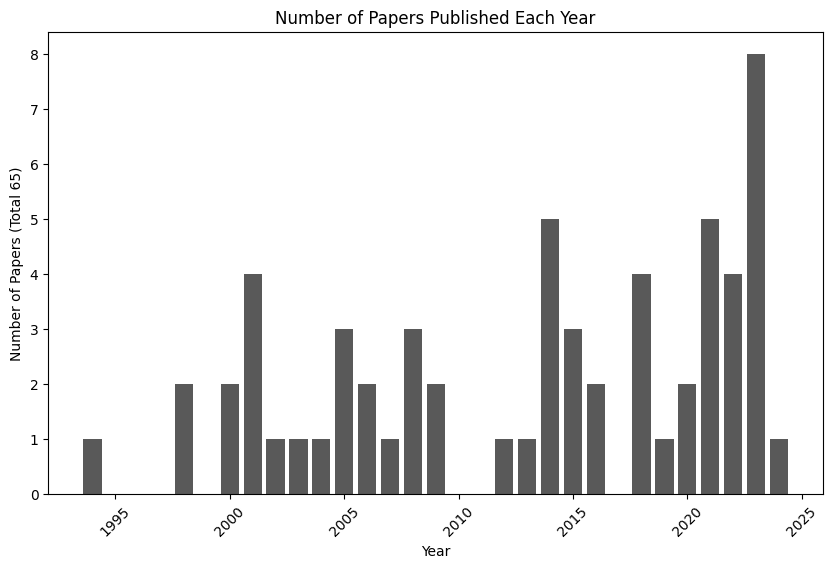

In [2]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Load the dataset
with open('./data/merged_results.json') as f:
    data = json.load(f)

# Total number of papers
num_papers = len(data)
print(f"Total number of papers: {num_papers}")

# Distribution of papers by publication year
years = []
for paper in data:
    try:
        # Ensure year is valid and convert to integer
        year = int(paper['year'])
        years.append(year)
    except (ValueError, TypeError):
        # Handle invalid or missing years
        pass

year_counts = Counter(years)

# Sort years for plotting
sorted_years = sorted(year_counts.keys())
sorted_counts = [year_counts[year] for year in sorted_years]

# Plotting the distribution of papers by year
plt.figure(figsize=(10, 6))
plt.bar(sorted_years, sorted_counts, color='#595959ff')
plt.title('Number of Papers Published Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers (Total 65)')
plt.xticks(rotation=45)
plt.show()


In [3]:
# Obtain all strings to obtain the fuzzy_mapper dictionaries

import json

# Load the JSON data
with open('./data/llm_responses.json') as f:
    data = json.load(f)

# Helper function to extract unique items from a field
def extract_unique_items(field):
    return set(
        item
        for paper in data
        if isinstance(paper.get(field), list)  # Ensure the field is a list
        for item in paper[field]
        if item  # Exclude None or empty values
    )

# Extract unique items for simple fields
unique_keywords = extract_unique_items('keywords')
unique_methodologies = extract_unique_items('methodologies')
unique_category_domains = extract_unique_items('category_domain')
unique_authors = set(
    author
    for paper in data
    if isinstance(paper.get('authors'), list)
    for author in paper['authors']
    if author
)
unique_performance_metrics = extract_unique_items('performance_metrics')
unique_ml_models_used = extract_unique_items('ml_models_used')
unique_datasets = extract_unique_items('datasets')

# Handle nested fields in intrusion_detection_systems
unique_ids_types = set()
unique_detection_methods = set()
unique_attack_types = set()
unique_evaluation_environments = set()

for paper in data:
    ids = paper.get('intrusion_detection_systems', {})
    if isinstance(ids.get('ids_type'), list):
        unique_ids_types.update(ids['ids_type'])
    if isinstance(ids.get('detection_methods'), list):
        unique_detection_methods.update(ids['detection_methods'])
    if isinstance(ids.get('attack_types'), list):
        unique_attack_types.update(ids['attack_types'])
    if ids.get('evaluation_environment'):
        unique_evaluation_environments.add(ids['evaluation_environment'])

# Print the unique items
print("Unique Keywords:", unique_keywords)
print()
print("Unique Methodologies:", unique_methodologies)
print()
print("Unique Category Domains:", unique_category_domains)
print()
print("Unique Authors:", unique_authors)
print()
print("Unique Performance Metrics:", unique_performance_metrics)
print()
print("Unique ML Models Used:", unique_ml_models_used)
print()
print("Unique Datasets:", unique_datasets)
print()
print("Unique IDS Types:", unique_ids_types)
print()
print("Unique Detection Methods:", unique_detection_methods)
print()
print("Unique Attack Types:", unique_attack_types)
print()
print("Unique Evaluation Environments:", unique_evaluation_environments)
print()

Unique Keywords: {'Ad Hoc Networks', 'Application-layer Protocols', 'One-vs-One', 'Multilayer Perceptron', 'Decision Trees', 'Markov blanket', 'support vector machine', 'Feature Selection', 'IDS', 'Network IDS', 'ROC curves', 'Least square support vector machine', 'Machine Learning', 'detection rate', 'Estimation of Distribution Algorithm', 'Intrusion detection', 'Collaboration', 'Cybersecurity', 'maximum likelihood', 'Network intrusion detection', 'Machine-learning', 'PSO', 'machine learning', 'Intrusion Detection', 'Streaming service', 'anomaly detection', 'KDD 99 Dataset', 'Artificial Neural Networks', 'Genetic algorithm', 'Evasion Attacks', 'Association Rules', 'AHP-TOPSIS', 'Sensor Fusion', 'security configuration', 'Layer wise Relevance Propagation', 'Cisco packet tracer', 'Intrusion detection systems', 'security', 'Distributed approaches', 'LIBSVM', 'Industry 4.0', 'Software Configuration', 'Peer-to-Peer', 'Bidirectional long short-term memory', 'inductive learning', 'Particle S

In [7]:
# Clean the fields with unified keywords for fuzzy occurrences
import sys
import os

# Add the current directory (or the specific folder) to Python's search path
sys.path.append(os.getcwd())

import json
from fuzzy_mappings import (
    keywords as keywords_mapping,
    methodologies as methodologies_mapping,
    category_domain as category_domain_mapping,
    authors as authors_mapping,
    performance_metrics as performance_metrics_mapping,
    ml_models_used as ml_models_used_mapping,
    datasets as datasets_mapping,
    detection_methods as detection_methods_mapping,
    attack_types as attack_types_mapping,
    evaluation_environment as evaluation_environment_mapping,
)

# Convert mappings to lowercase keys and values
def normalize_mapping(mapping):
    return {key.lower(): value.lower() for key, value in mapping.items()}

keywords_mapping = normalize_mapping(keywords_mapping)
methodologies_mapping = normalize_mapping(methodologies_mapping)
category_domain_mapping = normalize_mapping(category_domain_mapping)
authors_mapping = normalize_mapping(authors_mapping)
performance_metrics_mapping = normalize_mapping(performance_metrics_mapping)
ml_models_used_mapping = normalize_mapping(ml_models_used_mapping)
datasets_mapping = normalize_mapping(datasets_mapping)
detection_methods_mapping = normalize_mapping(detection_methods_mapping)
attack_types_mapping = normalize_mapping(attack_types_mapping)
evaluation_environment_mapping = normalize_mapping(evaluation_environment_mapping)

# Load the JSON data
input_file = './data/merged_results.json'
output_file = './data/cleaned_merged_results.json'

with open(input_file, 'r') as f:
    data = json.load(f)

# Function to map, clean, and deduplicate a list using a mapping dictionary
def clean_field(field_list, mapping):
    if not isinstance(field_list, list):
        return field_list  # Return as is if not a list
    cleaned = [mapping.get(item.lower(), item) for item in field_list]
    return list(set(cleaned))  # Remove duplicates by converting to a set and back to a list

# Function to clean and deduplicate nested fields
def clean_nested_fields(nested_data, mappings):
    if not isinstance(nested_data, dict):
        return nested_data  # Return as is if not a dictionary
    cleaned_data = {}
    for key, value in nested_data.items():
        mapping = mappings.get(key)
        if isinstance(value, list) and mapping:
            cleaned_data[key] = clean_field(value, mapping)
        else:
            cleaned_data[key] = value
    return cleaned_data

# Apply cleaning and deduplication to the JSON data
for paper in data:
    paper['keywords'] = clean_field(paper.get('keywords', []), keywords_mapping)
    paper['methodologies'] = clean_field(paper.get('methodologies', []), methodologies_mapping)
    paper['category_domain'] = clean_field(paper.get('category_domain', []), category_domain_mapping)
    paper['authors'] = clean_field(paper.get('authors', []), authors_mapping)
    paper['performance_metrics'] = clean_field(paper.get('performance_metrics', []), performance_metrics_mapping)
    paper['ml_models_used'] = clean_field(paper.get('ml_models_used', []), ml_models_used_mapping)
    paper['datasets'] = clean_field(paper.get('datasets', []), datasets_mapping)
    
    # Clean and deduplicate nested intrusion_detection_systems field
    if 'intrusion_detection_systems' in paper and isinstance(paper['intrusion_detection_systems'], dict):
        ids_data = paper['intrusion_detection_systems']

        # Check and clean detection_methods
        if 'detection_methods' in ids_data and isinstance(ids_data['detection_methods'], list):
            ids_data['detection_methods'] = clean_field(ids_data['detection_methods'], detection_methods_mapping)

        # Check and clean attack_types
        if 'attack_types' in ids_data and isinstance(ids_data['attack_types'], list):
            ids_data['attack_types'] = clean_field(ids_data['attack_types'], attack_types_mapping)

        # Check and clean evaluation_environment
        if 'evaluation_environment' in ids_data and isinstance(ids_data['evaluation_environment'], list):
            ids_data['evaluation_environment'] = clean_field(ids_data['evaluation_environment'], evaluation_environment_mapping)

# Save the cleaned and deduplicated data to the output file
with open(output_file, 'w') as f:
    json.dump(data, f, indent=4)

print(f"Cleaned data saved to {output_file}")

Cleaned data saved to ./data/cleaned_merged_results.json


Top Methodologies: [('intrusion detection', 15), ('decision trees', 14), ('machine learning', 12), ('data preprocessing', 10), ('computational intelligence', 7), ('neural networks', 7), ('optimization', 6), ('ensemble learning', 6), ('support vector machine', 5), ('bayesian networks', 5)]
Top Keywords: [('intrusion detection', 45), ('cybersecurity', 25), ('machine learning', 17), ('computational intelligence', 13), ('Intrusion Detection Systems', 8), ('neural networks', 7), ('iot', 6), ('data preprocessing', 6), ('ensemble learning', 6), ('decision trees', 6)]


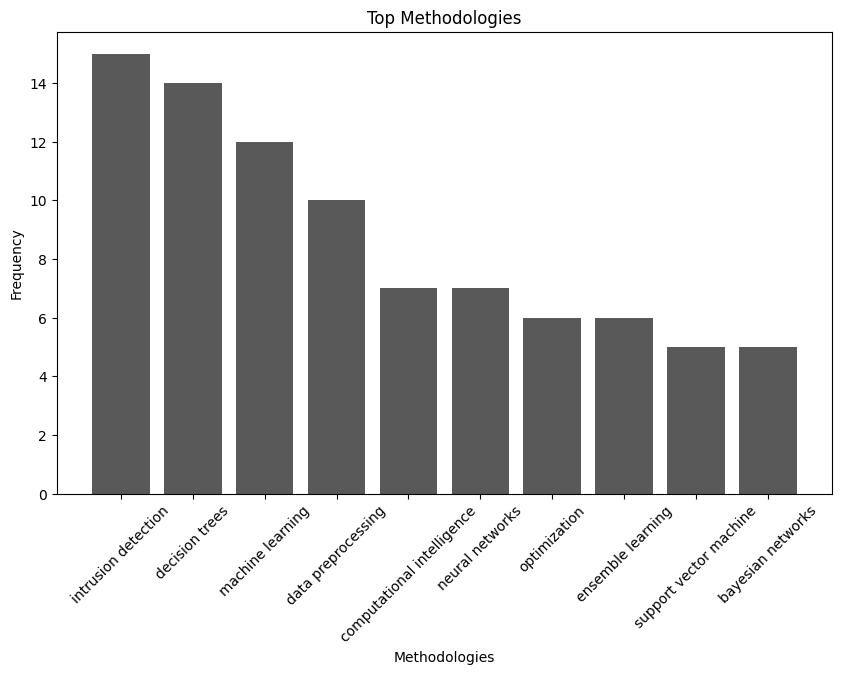

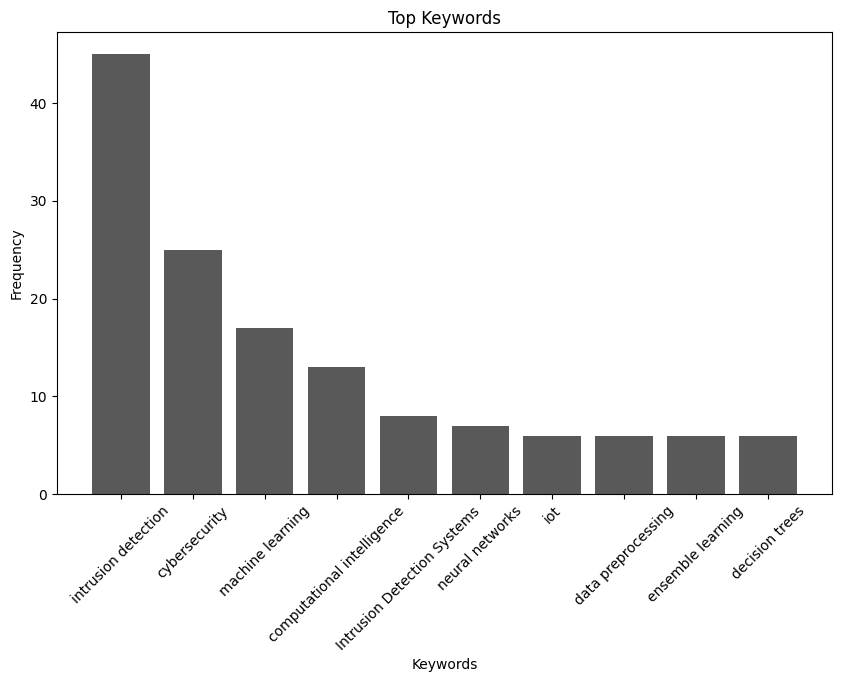

In [8]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Load the JSON data
with open('./data/cleaned_merged_results.json', 'r') as f:
    data = json.load(f)

# Ensure missing or None fields are handled gracefully
def safe_get(paper, field):
    value = paper.get(field, [])
    return value if isinstance(value, list) else []

# Most frequently mentioned methodologies and keywords
methodologies = [method for paper in data for method in safe_get(paper, 'methodologies') if method]
keywords = [kw for paper in data for kw in safe_get(paper, 'keywords') if kw]

method_counts = Counter(methodologies).most_common(10)
keyword_counts = Counter(keywords).most_common(10)

# Print top methodologies and keywords
print("Top Methodologies:", method_counts)
print("Top Keywords:", keyword_counts)

# Plotting top methodologies
plt.figure(figsize=(10, 6))
plt.bar([m[0] for m in method_counts], [m[1] for m in method_counts], color='#595959ff')
plt.title('Top Methodologies')
plt.xlabel('Methodologies')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Plotting top keywords
plt.figure(figsize=(10, 6))
plt.bar([kw[0] for kw in keyword_counts], [kw[1] for kw in keyword_counts], color='#595959ff')
plt.title('Top Keywords')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

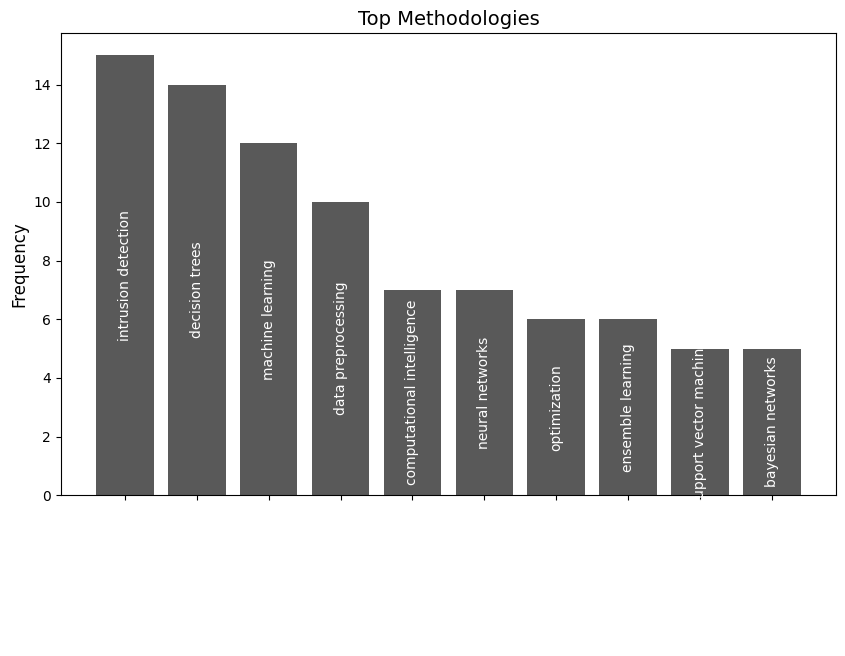

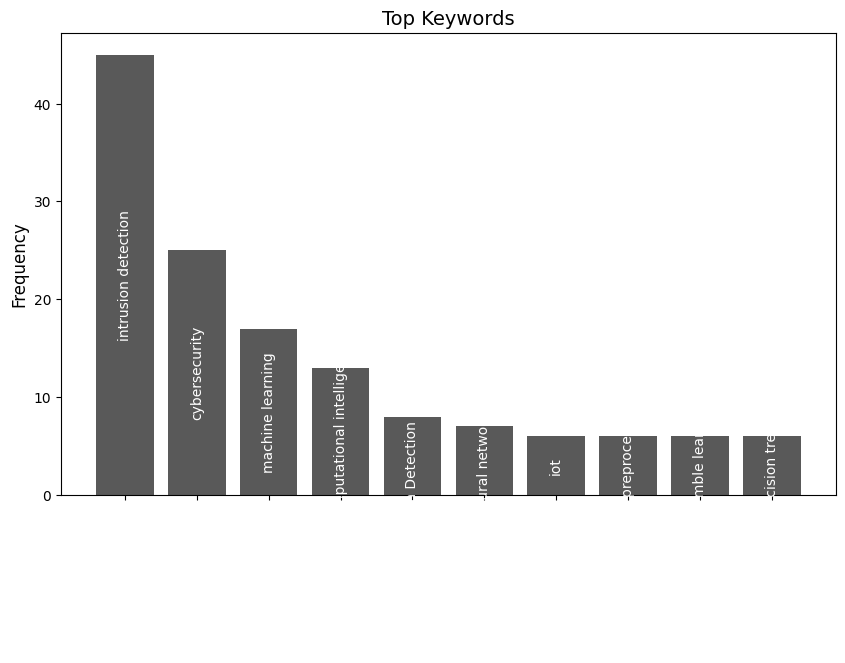

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# Helper function to add labels (keywords/methodologies) inside bars
def add_labels(ax, bars, labels):
    for bar, label in zip(bars, labels):
        if bar.get_height() > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Center of the bar
                bar.get_height() / 2,  # Place the label inside the bar
                label,  # Text to display (keyword/methodology)
                ha='center', va='center', rotation=90, color='white', fontsize=10
            )

# Plotting top methodologies
plt.figure(figsize=(10, 6))
method_counts = Counter(methodologies).most_common(10)
method_labels = [m[0] for m in method_counts]
method_frequencies = [m[1] for m in method_counts]

bars = plt.bar(method_labels, method_frequencies, color='#595959ff')
plt.title('Top Methodologies', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, fontsize=10, color='white')  # White x-label text

# Add methodology labels inside bars
ax = plt.gca()
add_labels(ax, bars, method_labels)

plt.show()

# Plotting top keywords
plt.figure(figsize=(10, 6))
keyword_counts = Counter(keywords).most_common(10)
keyword_labels = [k[0] for k in keyword_counts]
keyword_frequencies = [k[1] for k in keyword_counts]

bars = plt.bar(keyword_labels, keyword_frequencies, color='#595959ff')
plt.title('Top Keywords', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, fontsize=10, color='white')  # White x-label text

# Add keyword labels inside bars
ax = plt.gca()
add_labels(ax, bars, keyword_labels)

plt.show()

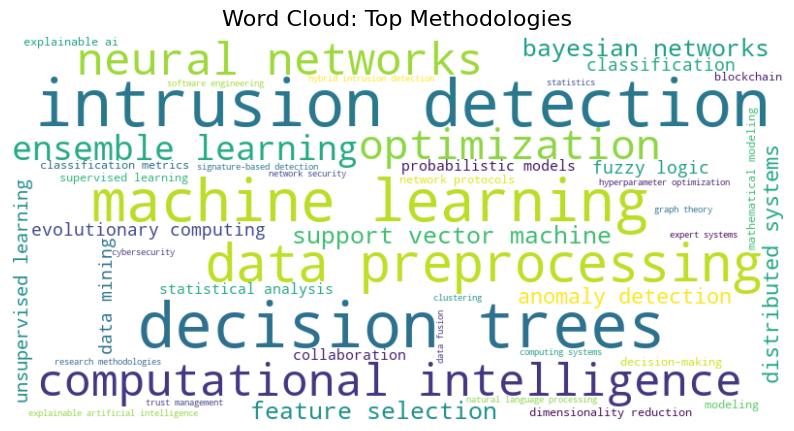

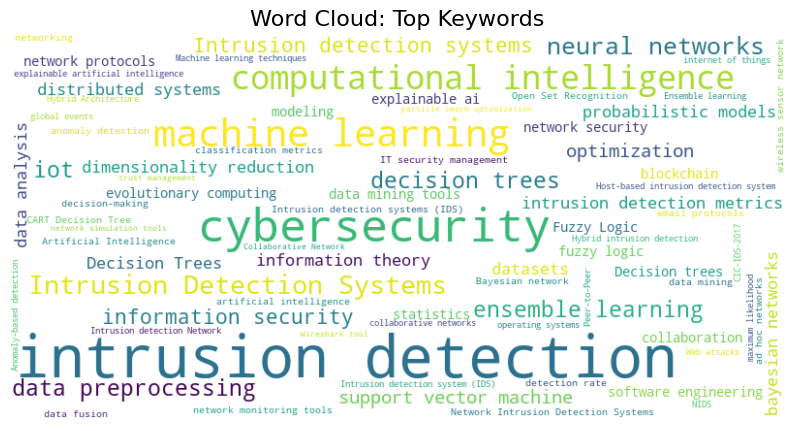

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Generate word cloud from a frequency dictionary
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(data)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Calculate frequency of methodologies and keywords
method_counts = Counter(methodologies)
keyword_counts = Counter(keywords)

# Generate word cloud for methodologies
generate_wordcloud(method_counts, "Word Cloud: Top Methodologies")

# Generate word cloud for keywords
generate_wordcloud(keyword_counts, "Word Cloud: Top Keywords")

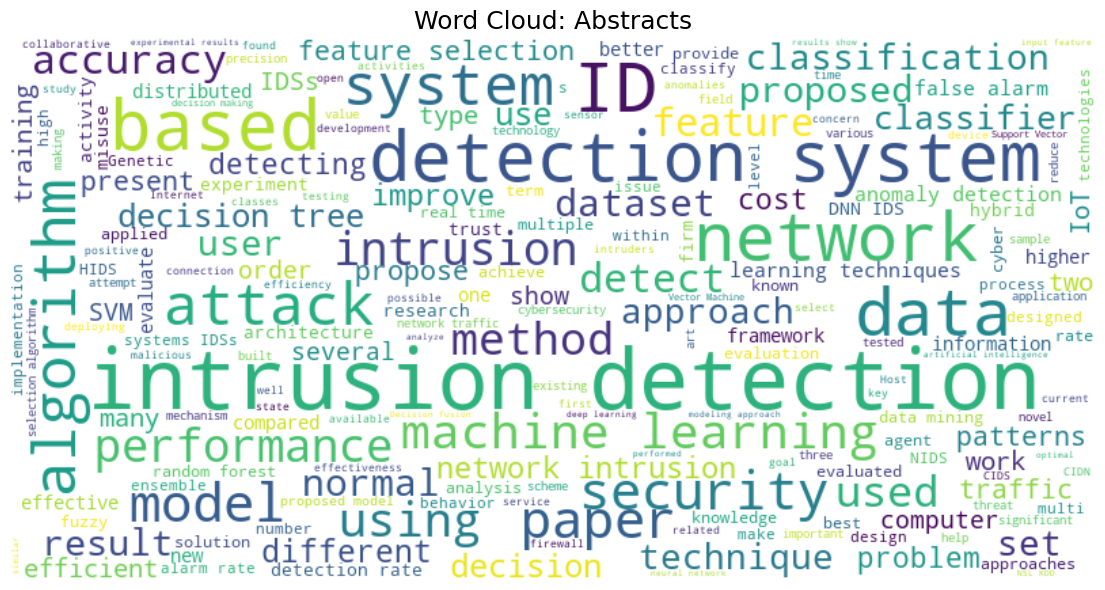

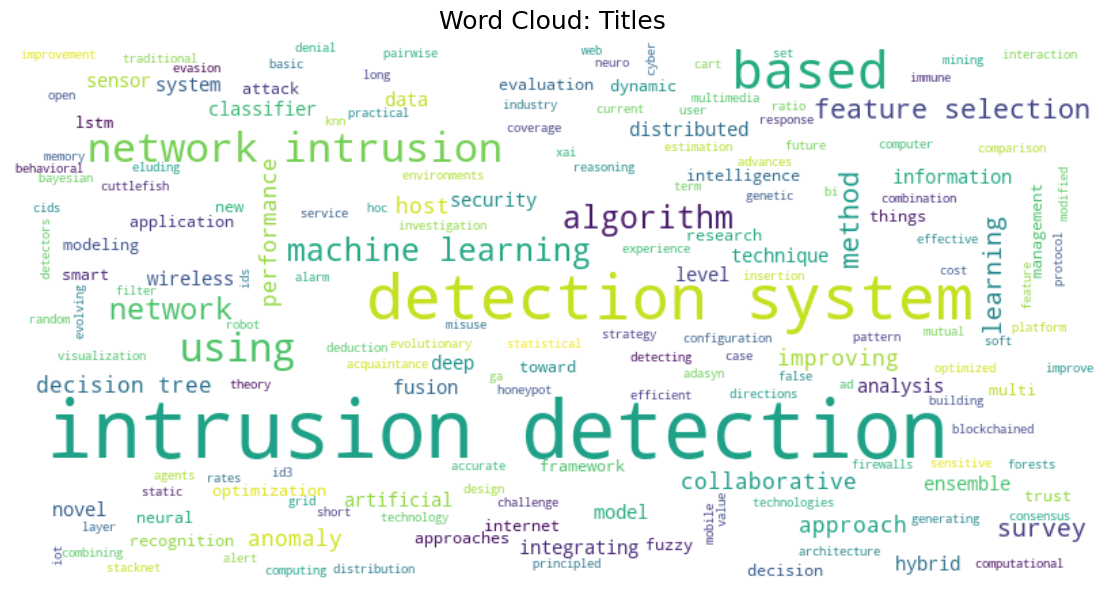

In [15]:
# Final attempt to resolve any remaining issues with word cloud generation

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ensure all abstracts and titles are properly concatenated and cleaned
abstract_text = " ".join([str(paper.get('abstract', '')).strip() for paper in data if paper.get('abstract')])
title_text = " ".join([str(paper.get('title', '')).strip() for paper in data if paper.get('title')])

# Function to generate and display a word cloud
def generate_wordcloud(text, title):
    if not text.strip():
        print(f"No text available to generate word cloud for {title}.")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate word clouds for abstract and title
generate_wordcloud(abstract_text, "Word Cloud: Abstracts")
generate_wordcloud(title_text, "Word Cloud: Titles")

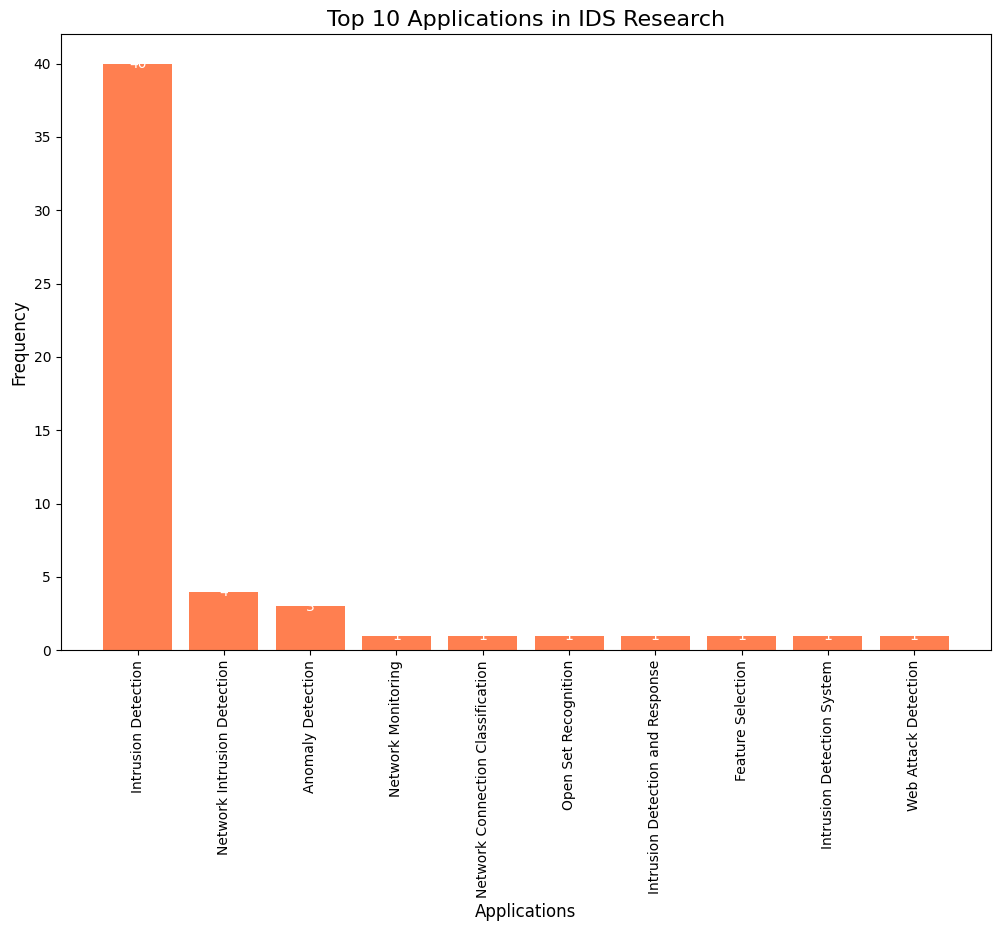

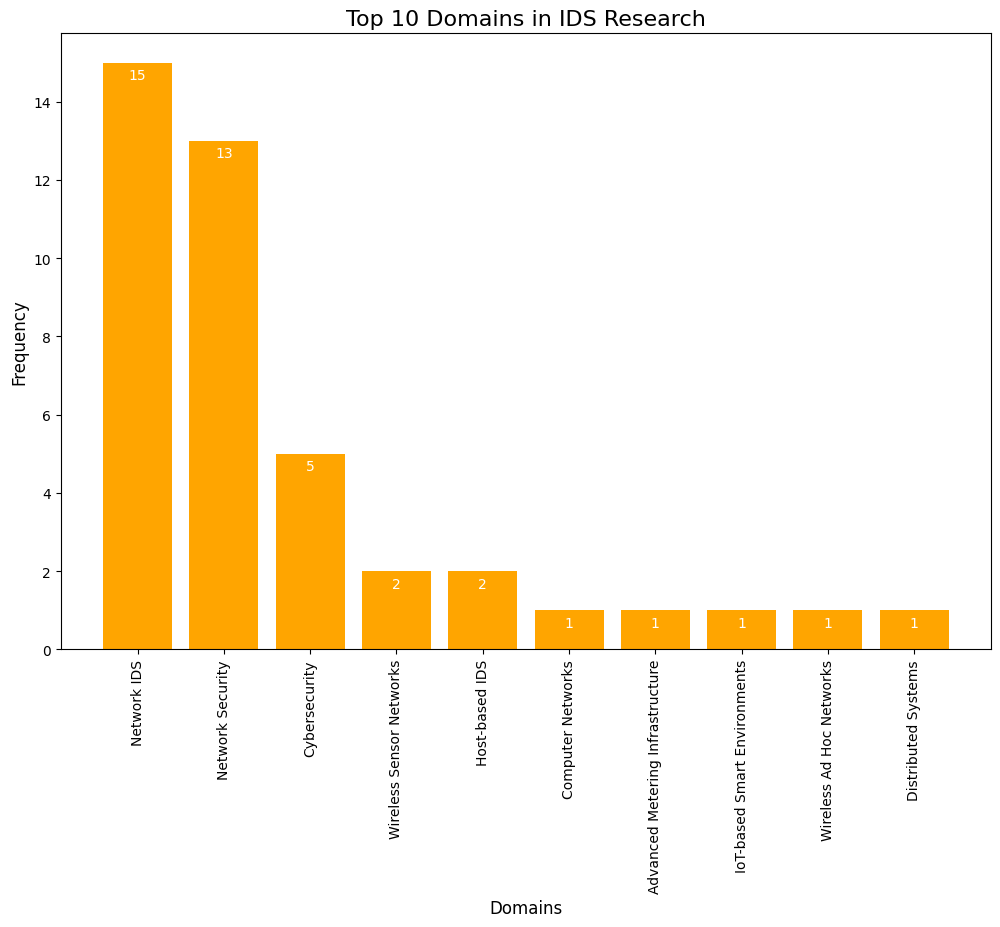

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

# Extract applications and domains
applications = [
    app['application_name']
    for paper in data
    for app in (paper.get('applications') or [])
    if isinstance(app, dict) and app.get('application_name')
]
domains = [
    app['domain']
    for paper in data
    for app in (paper.get('applications') or [])
    if isinstance(app, dict) and app.get('domain')
]

# Count and find the most common applications and domains
app_counts = Counter(applications).most_common(10)
domain_counts = Counter(domains).most_common(10)

# Plotting applications
plt.figure(figsize=(12, 8))
bars = plt.bar([a[0] for a in app_counts], [a[1] for a in app_counts], color='coral')
plt.title('Top 10 Applications in IDS Research', fontsize=16)
plt.xlabel('Applications', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# Adding proportional text labels inside the bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.5,
        bar.get_height(),
        ha='center', va='bottom', fontsize=10, color='white'
    )
plt.show()

# Plotting domains
plt.figure(figsize=(12, 8))
bars = plt.bar([d[0] for d in domain_counts], [d[1] for d in domain_counts], color='orange')
plt.title('Top 10 Domains in IDS Research', fontsize=16)
plt.xlabel('Domains', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

# Adding proportional text labels inside the bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.5,
        bar.get_height(),
        ha='center', va='bottom', fontsize=10, color='white'
    )
plt.show()

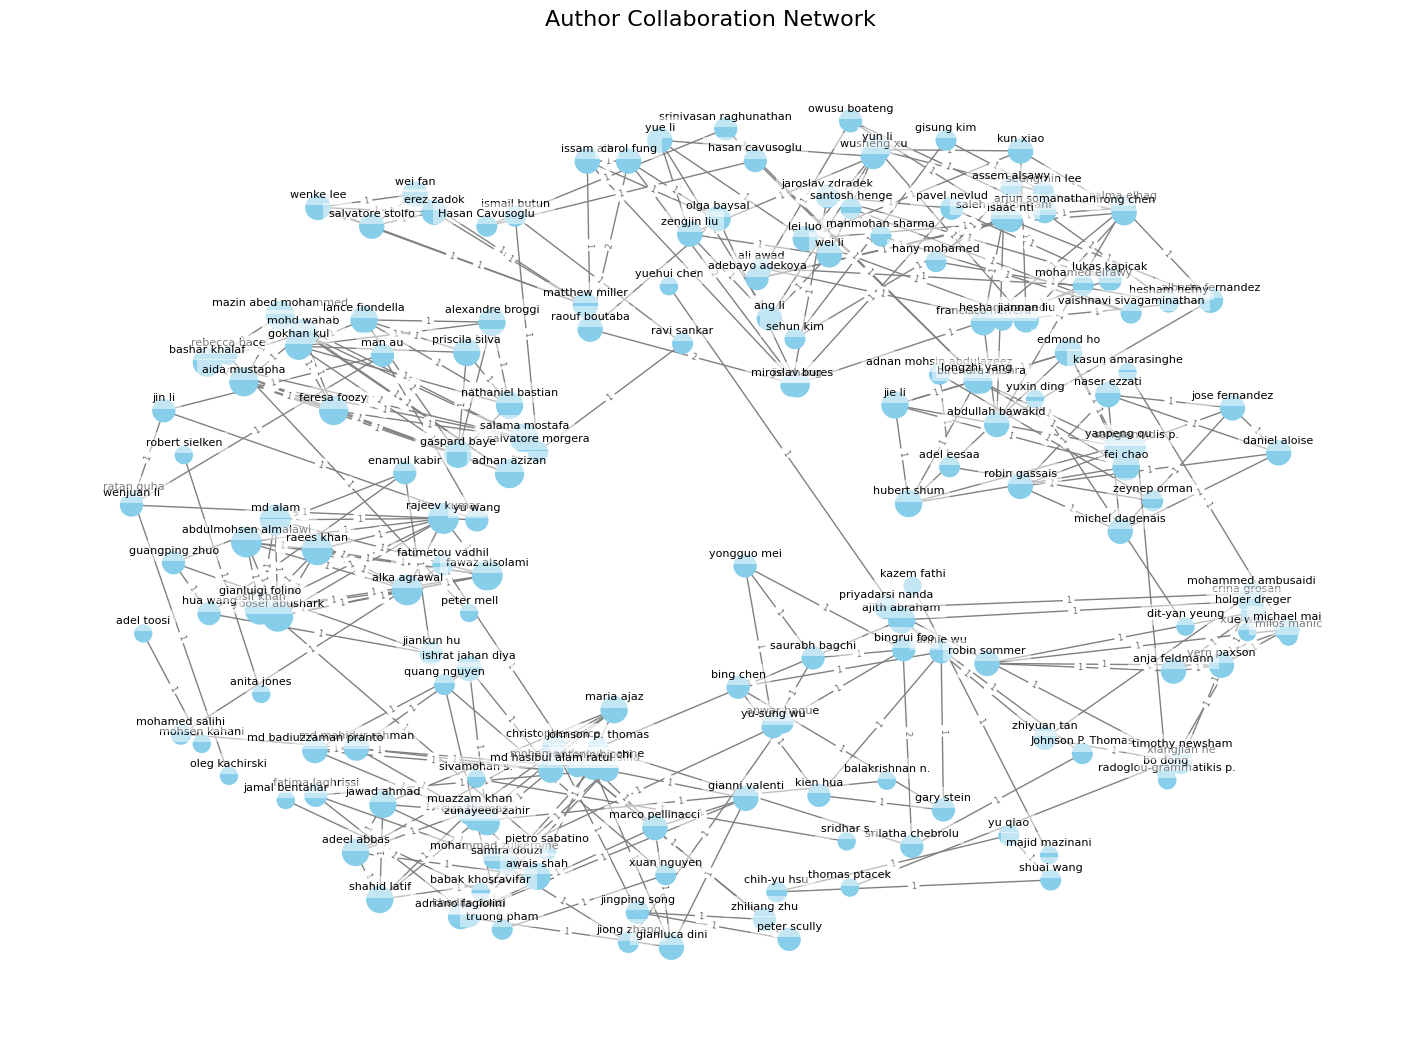

In [11]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Load the JSON data
input_file = './data/cleaned_merged_results.json'
with open(input_file, 'r') as f:
    data = json.load(f)

# Initialize the graph
G = nx.Graph()

# Build the graph from the data
for paper in data:
    authors = paper.get('authors', [])
    title = paper.get('title', 'Unknown Title')
    
    # Ensure authors is a list
    if not isinstance(authors, list) or len(authors) < 2:
        continue  # Skip if there are not enough authors for collaboration
    
    # Create edges for each pair of authors in the same paper
    for author_pair in combinations(authors, 2):
        # Add edge with the title as an attribute
        if G.has_edge(*author_pair):
            G[author_pair[0]][author_pair[1]]['papers'].append(title)
        else:
            G.add_edge(*author_pair, papers=[title])

# Assign node size based on degree (number of collaborations)
node_sizes = [100 + 50 * G.degree(node) for node in G.nodes]

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.5)  # Spring layout for better spacing

# Draw nodes and edges
nx.draw(
    G, pos, with_labels=False, node_size=node_sizes, node_color='skyblue', edge_color='gray', font_size=8
)

# Add author labels with better positioning and size
for author, position in pos.items():
    plt.text(
        position[0], position[1] + 0.03,  # Slight offset for better visibility
        s=author,
        fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )

# Add edge labels to display the number of shared papers
edge_labels = {
    (u, v): len(attr['papers'])
    for u, v, attr in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, alpha=0.6)

plt.title("Author Collaboration Network", fontsize=16)
plt.show()

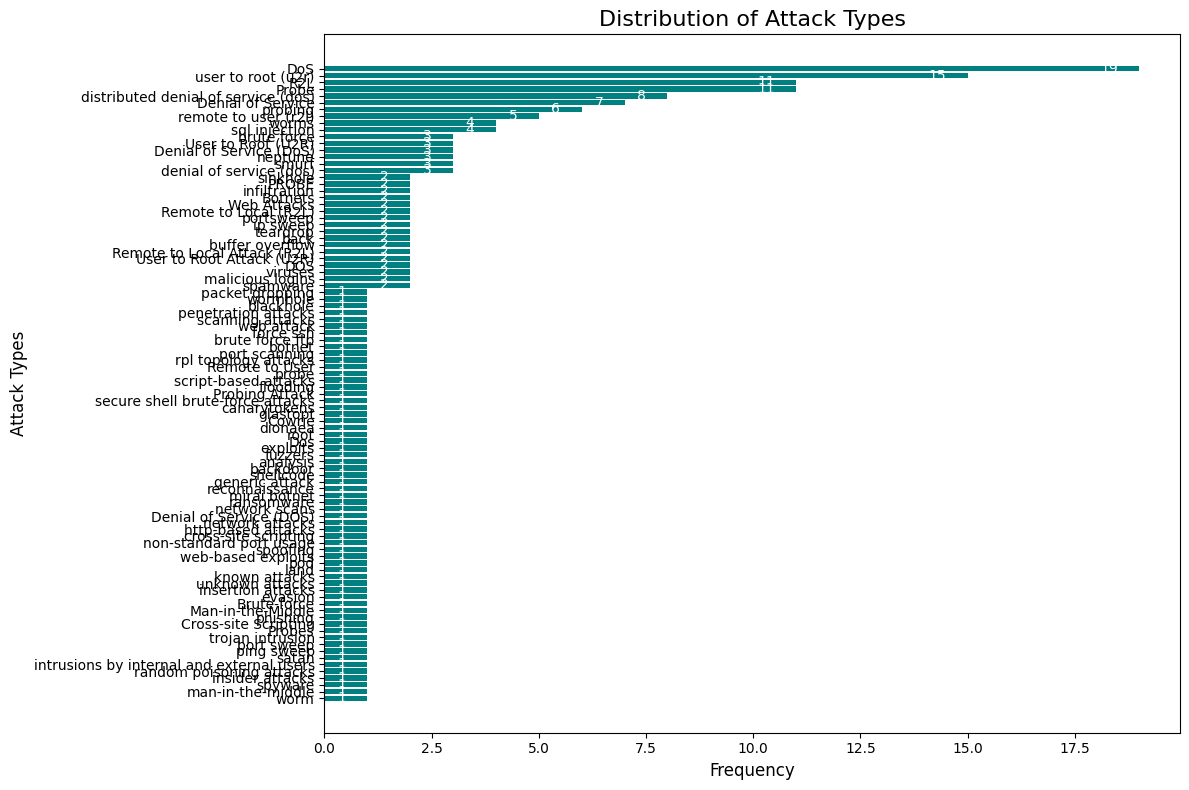

In [12]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Load the JSON data
input_file = './data/cleaned_merged_results.json'
with open(input_file, 'r') as f:
    data = json.load(f)

# Extract attack types
attack_types = []
for paper in data:
    intrusion_data = paper.get('intrusion_detection_systems', {})
    if isinstance(intrusion_data, dict):
        attack_types.extend(intrusion_data.get('attack_types', []))

# Count the frequency of attack types
attack_counts = Counter(attack_types).most_common()

# Separate attack types and their frequencies
attack_labels = [attack[0] for attack in attack_counts]
attack_frequencies = [attack[1] for attack in attack_counts]

# Plot the bar chart
plt.figure(figsize=(12, 8))
bar_height = 0.8  # Increase the bar height
bars = plt.barh(attack_labels, attack_frequencies, color='teal', height=bar_height)
plt.title('Distribution of Attack Types', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Attack Types', fontsize=12)

# Add labels inside the bars
for bar, frequency in zip(bars, attack_frequencies):
    plt.text(
        bar.get_width() - 0.5,  # Position text near the end of the bar
        bar.get_y() + bar.get_height() / 2,
        str(frequency),
        ha='right', va='center', color='white', fontsize=10
    )

plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

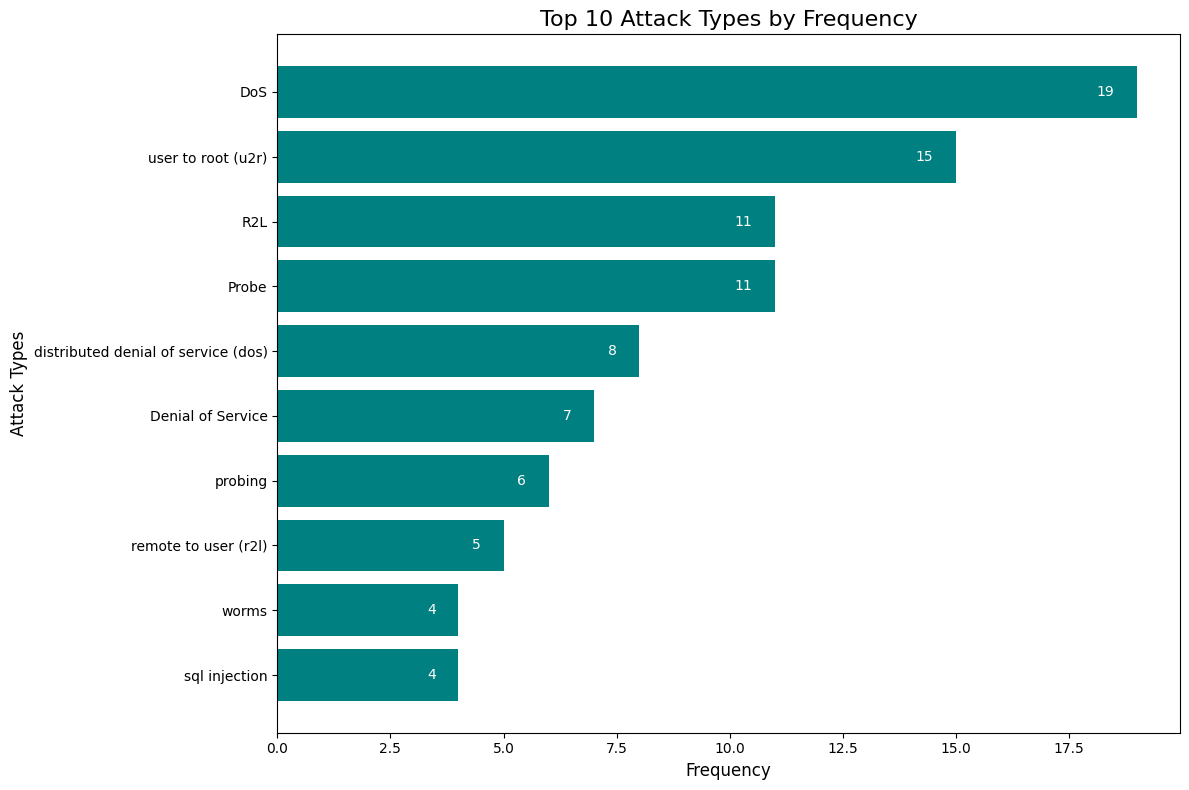

In [13]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Load the JSON data
input_file = './data/cleaned_merged_results.json'
with open(input_file, 'r') as f:
    data = json.load(f)

# Extract attack types
attack_types = []
for paper in data:
    intrusion_data = paper.get('intrusion_detection_systems', {})
    if isinstance(intrusion_data, dict):
        attack_types.extend(intrusion_data.get('attack_types', []))

# Count the frequency of attack types and limit to the top 10
top_n = 10
attack_counts = Counter(attack_types).most_common(top_n)

# Separate attack types and their frequencies
attack_labels = [attack[0] for attack in attack_counts]
attack_frequencies = [attack[1] for attack in attack_counts]

# Plot the bar chart
plt.figure(figsize=(12, 8))
bar_height = 0.8  # Increase the bar height for better readability
bars = plt.barh(attack_labels, attack_frequencies, color='teal', height=bar_height)
plt.title(f'Top {top_n} Attack Types by Frequency', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Attack Types', fontsize=12)

# Add labels inside the bars
for bar, frequency in zip(bars, attack_frequencies):
    plt.text(
        bar.get_width() - 0.5,  # Position text near the end of the bar
        bar.get_y() + bar.get_height() / 2,
        str(frequency),
        ha='right', va='center', color='white', fontsize=10
    )

plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

In [22]:
from prettytable import PrettyTable
from collections import Counter
import json

# Load the cleaned JSON data
input_file = './data/cleaned_merged_results.json'

with open(input_file, 'r') as f:
    data = json.load(f)

# Helper function to extract top 3 from a field with safety checks
def get_top_3(data, field):
    items = [
        item
        for paper in data
        if isinstance(paper.get(field, []), list)  # Ensure the field is a list
        for item in paper.get(field, [])
        if item  # Ignore None or empty items
    ]
    return Counter(items).most_common(3)

# Top 3 fields
top_keywords = get_top_3(data, 'keywords')
top_methodologies = get_top_3(data, 'methodologies')
top_authors = get_top_3(data, 'authors')
top_ml_models = get_top_3(data, 'ml_models_used')
top_datasets = get_top_3(data, 'datasets')

# Extract attack types with safety checks
top_attacks = [
    attack
    for paper in data
    if isinstance(paper.get('intrusion_detection_systems', {}), dict)
    for attack in paper['intrusion_detection_systems'].get('attack_types', [])
    if attack
]
top_attack_types = Counter(top_attacks).most_common(3)

# Top 3 papers by citations
try:
    top_cited_papers = sorted(
        [
            paper
            for paper in data
            if isinstance(paper.get('Citations'), int)  # Ensure citations is an integer
        ],
        key=lambda x: x.get('Citations', 0),
        reverse=True
    )[:3]
except KeyError:
    top_cited_papers = []

# Generate table for top categories
table = PrettyTable()
table.field_names = ["Category", "Top 3 Items"]

table.add_row(["Keywords", "\n".join([f"{item[0]} ({item[1]})" for item in top_keywords])])
table.add_row(["Methodologies", "\n".join([f"{item[0]} ({item[1]})" for item in top_methodologies])])
table.add_row(["Authors", "\n".join([f"{item[0]} ({item[1]})" for item in top_authors])])
table.add_row(["ML Models", "\n".join([f"{item[0]} ({item[1]})" for item in top_ml_models])])
table.add_row(["Datasets", "\n".join([f"{item[0]} ({item[1]})" for item in top_datasets])])
table.add_row(["Attack Types", "\n".join([f"{item[0]} ({item[1]})" for item in top_attack_types])])

# Generate table for top cited papers
citations_table = PrettyTable()
citations_table.field_names = ["Rank", "Title", "Citations"]

for i, paper in enumerate(top_cited_papers, 1):
    citations_table.add_row([i, paper['title'], paper.get('Citations', 'N/A')])

# Print the tables
print("Top Categories Table:")
print(table)
C
print("\nTop Cited Papers Table:")
print(citations_table)

Top Categories Table:
+---------------+-----------------------------+
|    Category   |         Top 3 Items         |
+---------------+-----------------------------+
|    Keywords   |   intrusion detection (45)  |
|               |      cybersecurity (25)     |
|               |    machine learning (17)    |
| Methodologies |   intrusion detection (15)  |
|               |     decision trees (14)     |
|               |    machine learning (12)    |
|    Authors    |      ajith abraham (4)      |
|               |        wenke lee (2)        |
|               |     salvatore stolfo (2)    |
|   ML Models   |      decision tree (26)     |
|               | support vector machine (14) |
|               |     neural networks (11)    |
|    Datasets   |          kdd99 (18)         |
|               |         nsl-kdd (11)        |
|               |        cicids2017 (5)       |
|  Attack Types |           DoS (19)          |
|               |   user to root (u2r) (15)   |
|               | 

In [27]:
import pandas as pd

# Data for Top Categories Table
categories_data = [
    ('Keywords', 'intrusion detection (45)'),
    ('Keywords', 'cybersecurity (25)'),
    ('Keywords', 'machine learning (17)'),
    ('Methodologies', 'intrusion detection (15)'),
    ('Methodologies', 'decision trees (14)'),
    ('Methodologies', 'machine learning (12)'),
    ('Authors', 'ajith abraham (4)'),
    ('Authors', 'wenke lee (2)'),
    ('Authors', 'salvatore stolfo (2)'),
    ('ML Models', 'decision tree (26)'),
    ('ML Models', 'support vector machine (14)'),
    ('ML Models', 'neural networks (11)'),
    ('Datasets', 'kdd99 (18)'),
    ('Datasets', 'nsl-kdd (11)'),
    ('Datasets', 'cicids2017 (5)'),
    ('Attack Types', 'DoS (19)'),
    ('Attack Types', 'user to root (u2r) (15)'),
    ('Attack Types', 'R2L (11)')
]

# Data for Top Cited Papers Table
cited_papers_data = [
    (1, 'data mining approaches for intrusion detection', 2183),
    (2, 'insertion, evasion, and denial of service: eluding network intrusion detection', 1496),
    (3, 'a survey of intrusion detection systems in wireless sensor networks', 1144)
]

# Convert the data to DataFrames
categories_df = pd.DataFrame(categories_data, columns=['Category', 'Top 3 Items'])
cited_papers_df = pd.DataFrame(cited_papers_data, columns=['Rank', 'Title', 'Citations'])

# Store the DataFrames into an Excel file
output_file = './top_categories_and_cited_papers.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    categories_df.to_excel(writer, sheet_name='Top Categories', index=False)
    cited_papers_df.to_excel(writer, sheet_name='Top Cited Papers', index=False)

print(f"Data successfully written to {output_file}")


Data successfully written to ./top_categories_and_cited_papers.xlsx


In [29]:
# Extract all two way approaches

import json

# Load the cleaned merged results
input_file = './data/cleaned_merged_results.json'

with open(input_file, 'r') as f:
    data = json.load(f)

# Extract two_way_approaches and their context and decisions
two_way_approaches_data = []

for paper in data:
    # Get the two_way_approaches, ensure it's a list (even if it's None)
    two_way_approaches = paper.get('two_way_approaches', [])
    if not isinstance(two_way_approaches, list):
        continue  # Skip if it's not a list (including if it's None)

    for approach in two_way_approaches:
        context = approach.get('context', 'Unknown Context')
        decisions = approach.get('decisions', [])
        
        two_way_approaches_data.append({
            'context': context,
            'decisions': decisions
        })

# Print the extracted two_way_approaches
for approach in two_way_approaches_data:
    print(f"Context: {approach['context']}")
    print(f"Decisions: {', '.join(approach['decisions'])}")
    print("-" * 50)

# Optional: Save the extracted data to a JSON or CSV file
# If you want to save the output as a JSON file:
with open('./data/two_way_approaches_extracted.json', 'w') as f:
    json.dump(two_way_approaches_data, f, indent=4)

# If you want to save the output as a CSV file:
import csv

csv_file = './data/two_way_approaches_extracted.csv'
with open(csv_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['context', 'decisions'])
    writer.writeheader()
    for row in two_way_approaches_data:
        writer.writerow(row)

print(f"Two-way approaches data saved to {csv_file}")

Context: Detection of DOS attacks
Decisions: DOS, NORMAL
--------------------------------------------------
Context: Detection of U2R attacks
Decisions: U2R, NORMAL
--------------------------------------------------
Context: Detection of R2L attacks
Decisions: R2L, NORMAL
--------------------------------------------------
Context: Detection of PROBE attacks
Decisions: PROBE, NORMAL
--------------------------------------------------
Context: Decision-making for whether activities are normal or intrusive.
Decisions: Normal, Intrusive
--------------------------------------------------
Context: Intrusion detection decision-making
Decisions: Intrusion detected, No intrusion detected
--------------------------------------------------
Context: Detection management through threshold-based alarm validation.
Decisions: Alarm triggers, No action
--------------------------------------------------
Context: Decision making in IDS using individual IDS and fusion unit outputs.
Decisions: Alert, No-ale

In [30]:
# Extract all three way approaches

import json

# Load the cleaned merged results
input_file = './data/cleaned_merged_results.json'

with open(input_file, 'r') as f:
    data = json.load(f)

# Extract three_way_approaches and their context and decisions
three_way_approaches_data = []

for paper in data:
    # Get the three_way_approaches, ensure it's a list (even if it's None)
    three_way_approaches = paper.get('three_way_approaches', [])
    if not isinstance(three_way_approaches, list):
        continue  # Skip if it's not a list (including if it's None)

    for approach in three_way_approaches:
        context = approach.get('context', 'Unknown Context')
        decisions = approach.get('decisions', [])
        
        three_way_approaches_data.append({
            'context': context,
            'decisions': decisions
        })

# Print the extracted three_way_approaches
for approach in three_way_approaches_data:
    print(f"Context: {approach['context']}")
    print(f"Decisions: {', '.join(approach['decisions'])}")
    print("-" * 50)

# Optional: Save the extracted data to a JSON or CSV file
# If you want to save the output as a JSON file:
with open('./data/three_way_approaches_extracted.json', 'w') as f:
    json.dump(three_way_approaches_data, f, indent=4)

# If you want to save the output as a CSV file:
import csv

csv_file = './data/three_way_approaches_extracted.csv'
with open(csv_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['context', 'decisions'])
    writer.writeheader()
    for row in three_way_approaches_data:
        writer.writerow(row)

print(f"Three-way approaches data saved to {csv_file}")

Context: Detection and classification of network traffic
Decisions: Normal Traffic, Anomalous Traffic, Unknown Traffic
--------------------------------------------------
Context: Multi-class classification among normal, DoS, and Probe attacks.
Decisions: Normal, DoS, Probe
--------------------------------------------------
Context: Handling Ambiguous Traffic Scenarios
Decisions: Insertion Attack, Evasion Attack, Denial of Service
--------------------------------------------------
Context: Expertise levels in trust management
Decisions: Low expertise, Medium expertise, High expertise
--------------------------------------------------
Three-way approaches data saved to ./data/three_way_approaches_extracted.csv


In [31]:
# Extract all four way approaches

import json

# Load the cleaned merged results
input_file = './data/cleaned_merged_results.json'

with open(input_file, 'r') as f:
    data = json.load(f)

# Extract four_way_approaches and their context and decisions
four_way_approaches_data = []

for paper in data:
    # Get the four_way_approaches, ensure it's a list (even if it's None)
    four_way_approaches = paper.get('four_way_approaches', [])
    if not isinstance(four_way_approaches, list):
        continue  # Skip if it's not a list (including if it's None)

    for approach in four_way_approaches:
        context = approach.get('context', 'Unknown Context')
        decisions = approach.get('decisions', [])
        
        four_way_approaches_data.append({
            'context': context,
            'decisions': decisions
        })

# Print the extracted four_way_approaches
for approach in four_way_approaches_data:
    print(f"Context: {approach['context']}")
    print(f"Decisions: {', '.join(approach['decisions'])}")
    print("-" * 50)

# Optional: Save the extracted data to a JSON or CSV file
# If you want to save the output as a JSON file:
with open('./data/four_way_approaches_extracted.json', 'w') as f:
    json.dump(four_way_approaches_data, f, indent=4)

# If you want to save the output as a CSV file:
import csv

csv_file = './data/four_way_approaches_extracted.csv'
with open(csv_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['context', 'decisions'])
    writer.writeheader()
    for row in four_way_approaches_data:
        writer.writerow(row)

print(f"Four-way approaches data saved to {csv_file}")

Context: Intrusion decision-making in IDS
Decisions: Intrusive but not anomalous, Not intrusive but anomalous, Not intrusive and not anomalous, Intrusive and anomalous
--------------------------------------------------
Context: Classification of attack types into four main categories.
Decisions: Normal, Probe, DoS, R2L, U2R
--------------------------------------------------
Context: Classification of network attacks
Decisions: Normal, DOS, U2R, R2L, Probe
--------------------------------------------------
Four-way approaches data saved to ./data/four_way_approaches_extracted.csv
